# Project IART Class - COVID-19 mobility reports - Part 2
## Machine Learning Analysis - Regression problems



## Third Regression Problem: adding some new features for predicting total_cases & PCA and ExtraTreesRegressor for chosing appropriate features

We added now a few more data to our dataset, such as: 

 * total cases by 1 Million of population [1]
 * fatalities by 1 Million of population [1]
 * IBP - Internal Brut Product [2]
 * Ranking of the efficience of the health system [3]
 
We hope they help us to make better predictions.

In this part of our project, we will also be performing PCA [4] to reduce the feature space and compare results as a dimensionality reduction algorithm. For feature selection we use ExtraTreesRegressor [5].


[1] - https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population 

[2] - https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_PIB_nominal

[3] - https://www.who.int/healthinfo/paper30.pdf

[4] - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

[5] - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [1]:
#Main imports
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb
import sys
import os

#Import modules for models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model #linear_model.SGDRegressor()
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn import tree #tree.DecisionTreeRegressor()
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#Import modules for metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [2]:
code_path=os.getcwd()
data_path=code_path.replace('code','data')
print("Code path : ",code_path)
print("Data path : ",data_path)

Code path :  /home/fatimab/IART_classes/COVID-19/code
Data path :  /home/fatimab/IART_classes/COVID-19/data


In [3]:
os.chdir(data_path)
covid_data=pd.read_csv("data_2.csv",na_values=["NA"])
os.chdir(code_path)
countries_column=np.array(covid_data.loc[:,"country"])
countries=np.unique(countries_column)
days=np.arange(43)
days_column=np.tile(days,countries.shape[0])
covid_data.loc[:,"date"]=days_column
covid_data.head()

,iso,country,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,total_cases_1m,fatalities_1m,pib,health_system_efficiency
0,AR,Argentina,0,8.185,17.563,0.437,13.644,5.334,-2.486,0,0,0.0,0.0,519487,0.722
1,AR,Argentina,1,-15.875,25.605,6.321,-9.973,-26.785,-53.687,0,0,0.0,0.0,519487,0.722
2,AR,Argentina,2,-17.135,1.325,6.895,-19.717,-28.485,-50.053,0,0,0.0,0.0,519487,0.722
3,AR,Argentina,3,2.304,5.399,-2.273,0.845,9.461,12.584,0,0,0.0,0.0,519487,0.722
4,AR,Argentina,4,-0.404,-5.267,-0.493,-0.584,7.983,12.407,0,0,0.0,0.0,519487,0.722


# Analysis of features
Firstly, let's do a analysis of what data is more important in order to calculate the number of total cases.

In [4]:
cases_previous_7days=[]
for i in range(0,len(covid_data.date)):
  if covid_data.date[i]<=6: 
    cases_previous_7days.append(-1)
  else:
    cases_previous_7days.append(covid_data.total_cases_1m[i-7])

    
cases_previous_7days=np.array(cases_previous_7days)

covid_data["total_cases_7days"]=cases_previous_7days

first_week=(covid_data.total_cases_7days!=-1)
second_data=covid_data[first_week]
second_data=covid_data.reset_index(drop=True)



In [5]:
covid_data.describe()

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,total_cases_1m,fatalities_1m,pib,health_system_efficiency,total_cases_7days
count,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,8.170000e+02,817.000000,817.000000
mean,21.000000,-8.229424,-13.394035,9.545845,-26.205257,-28.370122,-19.126192,10699.773562,566.007344,144.442749,9.084531,2.618162e+06,0.804053,65.793767
std,12.417275,21.313369,32.891636,10.545377,30.992728,30.211025,25.983021,31656.464952,2008.520488,365.319419,34.593547,4.376739e+06,0.168450,199.956429
min,0.000000,-84.798000,-91.456000,-3.647000,-95.158000,-88.956000,-79.293000,0.000000,0.000000,0.000000,0.000000,3.681350e+05,0.319000,-1.000000
25%,10.000000,-16.578000,-32.841000,0.744000,-49.975000,-54.145000,-40.582000,27.000000,0.000000,0.323912,0.000000,7.712740e+05,0.722000,0.000000
50%,21.000000,0.088000,-6.498000,5.912000,-14.427000,-19.502000,-8.395000,648.000000,6.000000,6.706333,0.084942,1.427533e+06,0.876000,1.167130
75%,32.000000,4.838000,6.961000,16.695000,-0.632000,-0.970000,1.037000,4585.000000,79.000000,102.431506,1.010231,2.718732e+06,0.925000,20.806102
max,42.000000,59.474000,75.002000,40.343000,19.699000,16.822000,21.347000,336912.000000,15887.000000,2795.008348,268.384155,2.058025e+07,0.994000,1700.834957


In [6]:
all_features=covid_data[['grocery_pharmacy','parks','residential','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']].values
all_labels=covid_data['total_cases_1m'].values
all_groups=np.array(covid_data.loc[:,"country"])


print("Features shape : ",all_features.shape)
print("All labels shape : ", all_labels.shape)
print("All groups shape : ", all_groups.shape)

Features shape :  (817, 9)
All labels shape :  (817,)
All groups shape :  (817,)


In [7]:
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

#Define number of splits
n_splits=5

group_kfold=GroupKFold(n_splits=n_splits)
print("Splits", group_kfold.get_n_splits(all_features,all_labels,all_groups))
print(group_kfold)

Splits 5
GroupKFold(n_splits=5)


### PCA Analysis 
Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

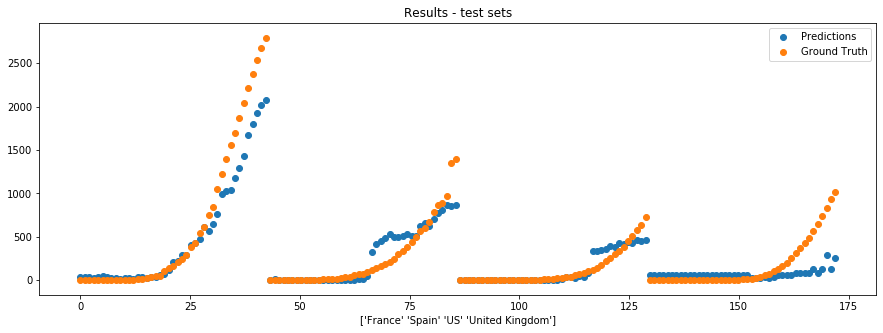

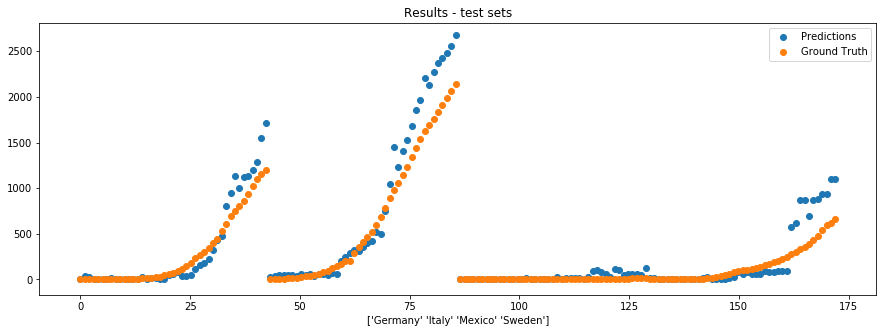

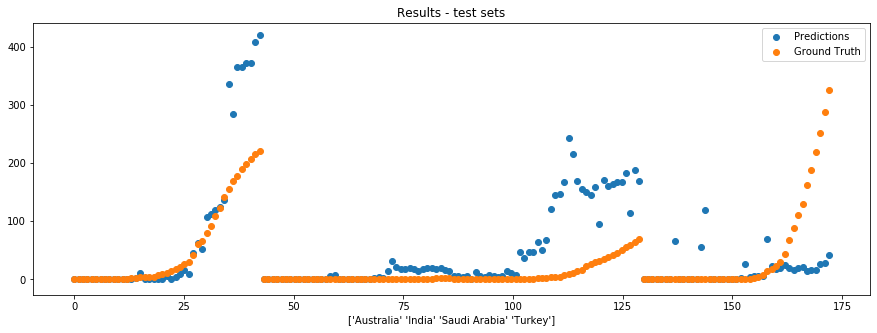

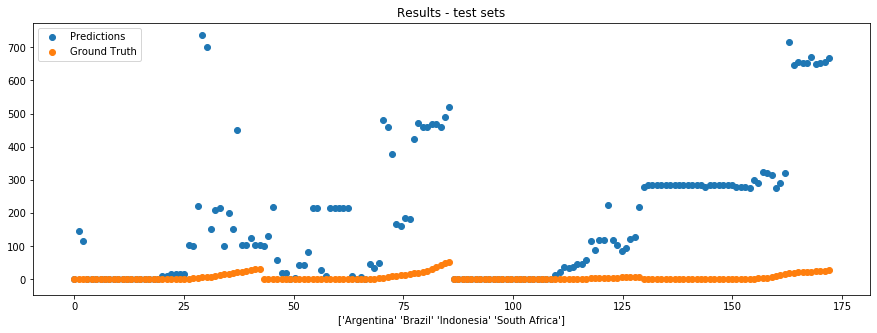

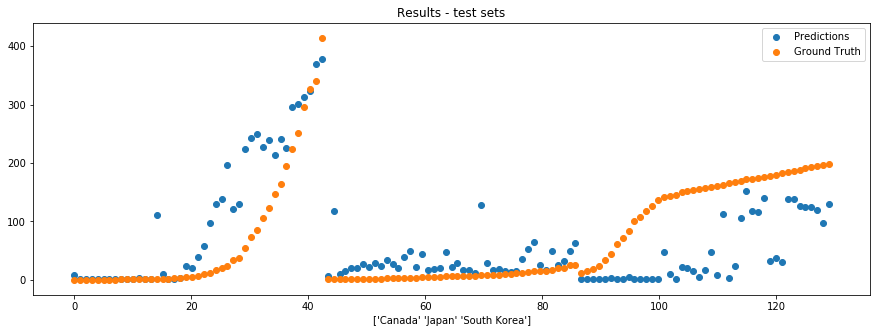

In [9]:

train_r2scores=[]
test_r2scores=[]
train_mse_scores=[]
test_mse_scores=[]
train_maxerror_scores=[]
test_maxerror_scores=[]
train_mae_scores=[]
test_mae_scores=[]

train_r2scores_scaled=[]
test_r2scores_scaled=[]
test_mae_scores_scaled=[]
train_mse_scores_scaled=[]
test_mse_scores_scaled=[]
train_maxerror_scores_scaled=[]
test_maxerror_scores_scaled=[]
train_mae_scores_scaled=[]

for train_idx,test_idx in group_kfold.split(all_features,all_labels,all_groups):
    #Train set
    train_countries=np.unique(np.array(covid_data.loc[train_idx]["country"]))
    X_train=all_features[train_idx]
    y_train=all_labels[train_idx]
    
    #Test & Validation set
    test_countries=np.unique(np.array(covid_data.loc[test_idx]["country"]))
    X_test=all_features[test_idx]
    y_test=all_labels[test_idx]

    #Scaling the data 
    scaler=StandardScaler()    
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    #PCA
    pca=PCA(0.95)
    pca.fit(X_train)
    X_train_PCA=pca.transform(X_train)
    X_test_PCA=pca.transform(X_test)
    
    
    model=RandomForestRegressor()
    #model=tree.DecisionTreeRegressor(max_depth=10)
    #model=MLPRegressor(hidden_layer_sizes=(100,),learning_rate='adaptive',max_iter=500)
    model.fit(X_train_PCA,y_train)
    
    predictions_train=model.predict(X_train_PCA)
    predictions_test=model.predict(X_test_PCA)
    
    #Scale the predicted and label values to [0,1] range
    scaler_l=MinMaxScaler()
    #y
    y_train_scaled=y_train.reshape(-1,1)
    y_train_scaled=scaler_l.fit_transform(y_train_scaled)
    y_train_scaled=y_train_scaled.reshape(-1)
    
    y_test_scaled=y_test.reshape(-1,1)
    y_test_scaled=scaler_l.fit_transform(y_test_scaled)
    y_test_scaled=y_test_scaled.reshape(-1)
    #pred
    predictions_train_scaled=predictions_train.reshape(-1,1)
    predictions_train_scaled=scaler_l.fit_transform(predictions_train_scaled)
    predictions_train_scaled=predictions_train_scaled.reshape(-1)       
    
    predictions_test_scaled=predictions_test.reshape(-1,1)
    predictions_test_scaled=scaler_l.fit_transform(predictions_test_scaled)
    predictions_test_scaled=predictions_test_scaled.reshape(-1)
      
        
    #Calculate values of metrics
    #Non-scaled
    r2_train=r2_score(y_train,predictions_train)
    r2_test=r2_score(y_test,predictions_test)
    
    mse_train=mse(y_train,predictions_train)
    mse_test=mse(y_test,predictions_test)
    
    me_train=max_error(y_train,predictions_train)
    me_test=max_error(y_test,predictions_test)
    
    mae_train=mean_absolute_error(y_train,predictions_train)
    mae_test=mean_absolute_error(y_test,predictions_test)    
    
    #Scaled
    r2_train_scaled=r2_score(y_train_scaled,predictions_train_scaled)
    r2_test_scaled=r2_score(y_test_scaled,predictions_test_scaled)
    
    mse_train_scaled=mse(y_train_scaled,predictions_train_scaled)
    mse_test_scaled=mse(y_test_scaled,predictions_test_scaled)
    
    me_train_scaled=max_error(y_train_scaled,predictions_train_scaled)
    me_test_scaled=max_error(y_test_scaled,predictions_test_scaled)
    
    mae_train_scaled=mean_absolute_error(y_train_scaled,predictions_train_scaled)
    mae_test_scaled=mean_absolute_error(y_test_scaled,predictions_test_scaled)  
    
    
    #Save results
    #Non-scaled
    train_r2scores.append(round(r2_train,4))
    test_r2scores.append(round(r2_test,4))
    
    train_mse_scores.append(round(mse_train,4))
    test_mse_scores.append(round(mse_test,4))
    
    train_maxerror_scores.append(round(me_train,4))
    test_maxerror_scores.append(round(me_test,4))
    
    train_mae_scores.append(round(mae_train,4))
    test_mae_scores.append(round(mae_test,4))
    
    #Scaled
    train_r2scores_scaled.append(round(r2_train_scaled,4))
    test_r2scores_scaled.append(round(r2_test_scaled,4))
    
    train_mse_scores_scaled.append(round(mse_train_scaled,4))
    test_mse_scores_scaled.append(round(mse_test_scaled,4))
    
    train_maxerror_scores_scaled.append(round(me_train_scaled,4))
    test_maxerror_scores_scaled.append(round(me_test_scaled,4))
    
    train_mae_scores_scaled.append(round(mae_train_scaled,4))
    test_mae_scores_scaled.append(round(mae_test_scaled,4))
    
    #Plot unscaled test results
    fig=plt.figure(figsize=(15,5))
    x=np.linspace(0,len(predictions_test),len(predictions_test))
    plt.scatter(x,predictions_test,label="Predictions")
    plt.scatter(x,y_test,label="Ground Truth")
    plt.xlabel(str(test_countries))
    plt.legend()
    plt.title("Results - test sets")
    plt.show()
    
    
results_train=pd.DataFrame(list(zip(train_r2scores,train_r2scores_scaled,train_mse_scores,train_mse_scores_scaled,train_maxerror_scores,train_maxerror_scores_scaled,train_mae_scores,train_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])

results_test=pd.DataFrame(list(zip(test_r2scores,test_r2scores_scaled,test_mse_scores,test_mse_scores_scaled,test_maxerror_scores,test_maxerror_scores_scaled,test_mae_scores,test_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])




### Results train

In [10]:
results_train

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9970,0.9973,238.8362,0.0000,107.3593,0.0496,6.9479,0.0031
1,0.9978,0.9978,216.9886,0.0000,91.8333,0.0450,6.7106,0.0023
2,0.9939,0.9865,993.3387,0.0003,256.2721,0.1402,13.2205,0.0067
3,0.9937,0.9901,1026.7535,0.0002,251.8380,0.1358,14.3865,0.0058
4,0.9945,0.9889,849.3391,0.0002,218.9170,0.1353,11.9878,0.0055


In [11]:
results_train.describe()

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.995380,0.992120,665.051220,0.000140,185.243940,0.101180,10.650660,0.004680
std,0.001889,0.005127,404.654972,0.000134,79.695057,0.049249,3.591066,0.001882
min,0.993700,0.986500,216.988600,0.000000,91.833300,0.045000,6.710600,0.002300
25%,0.993900,0.988900,238.836200,0.000000,107.359300,0.049600,6.947900,0.003100
50%,0.994500,0.990100,849.339100,0.000200,218.917000,0.135300,11.987800,0.005500
75%,0.997000,0.997300,993.338700,0.000200,251.838000,0.135800,13.220500,0.005800
max,0.997800,0.997800,1026.753500,0.000300,256.272100,0.140200,14.386500,0.006700


### Results test

In [12]:
results_test

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.8460,0.8952,46410.0859,0.0040,802.9406,0.2714,118.8613,0.0383
1,0.8492,0.9650,35909.5690,0.0018,586.6201,0.1699,107.9955,0.0262
2,-0.5286,0.0106,5859.8707,0.0358,283.3816,0.8995,41.1484,0.0986
3,-609.0780,-0.5859,65671.7086,0.0616,729.3888,0.8727,173.3020,0.1663
4,0.2995,0.2313,5513.8804,0.0353,172.1215,0.4668,53.5462,0.1352


In [13]:
results_test.describe()

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000
mean,-121.522380,0.303240,31873.022920,0.027700,514.890520,0.53606,98.970680,0.092920
std,272.552459,0.646089,26179.474502,0.025025,276.231096,0.33702,53.406528,0.060497
min,-609.078000,-0.585900,5513.880400,0.001800,172.121500,0.16990,41.148400,0.026200
25%,-0.528600,0.010600,5859.870700,0.004000,283.381600,0.27140,53.546200,0.038300
50%,0.299500,0.231300,35909.569000,0.035300,586.620100,0.46680,107.995500,0.098600
75%,0.846000,0.895200,46410.085900,0.035800,729.388800,0.87270,118.861300,0.135200
max,0.849200,0.965000,65671.708600,0.061600,802.940600,0.89950,173.302000,0.166300


### ExtraTreesRegressor

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. (Transcribed)

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

#Scaling the data 
scaler=StandardScaler()    
X_train=scaler.fit_transform(all_features)
y_train=(all_labels)


#ExtraTreesClassifier
model_c=ExtraTreesRegressor()
model_c.fit(X_train,y_train)
features_names=['grocery_pharmacy','parks','residential','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']
for i in range(len(features_names)):
    print(features_names[i],model_c.feature_importances_[i])
#print(model_c.feature_importances_)



grocery_pharmacy 0.015363279570532016
parks 0.011518703553350183
residential 0.005320117654670108
retail_recreation 0.05002753730423936
transit_stations 0.025914029275495375
workplaces 0.021594643312707593
total_cases_7days 0.8358533732686597
pib 0.010311201925545717
health_system_efficiency 0.024097114134799962


Let's delete grocery_pharmacy & residential, since they don't have a lot of weight in the model!

In [15]:
all_features_2=covid_data[['parks','retail_recreation','transit_stations','workplaces','total_cases_7days','pib','health_system_efficiency']].values


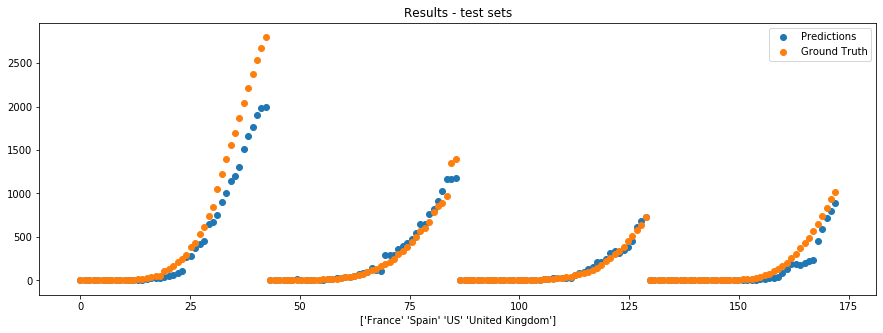

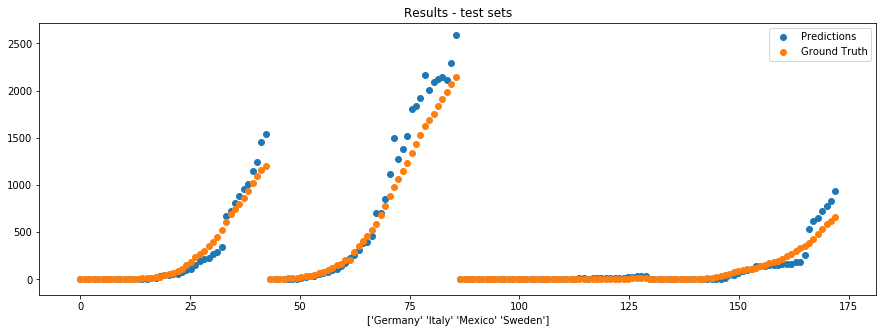

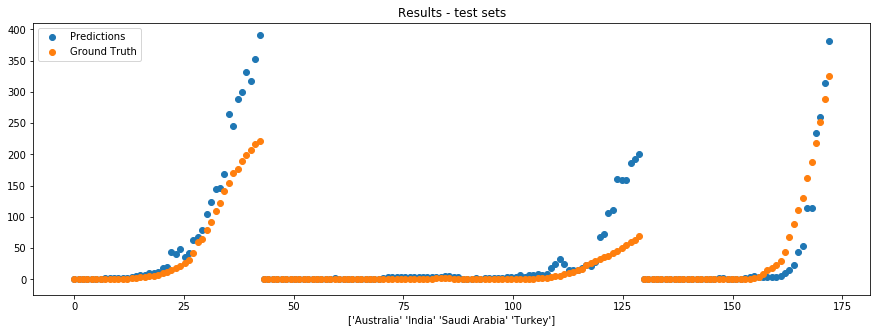

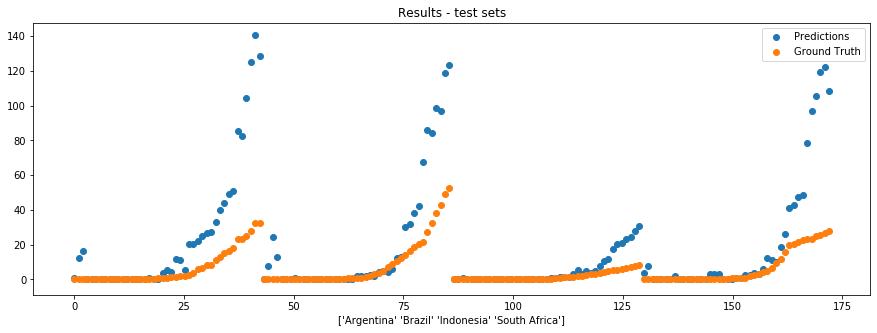

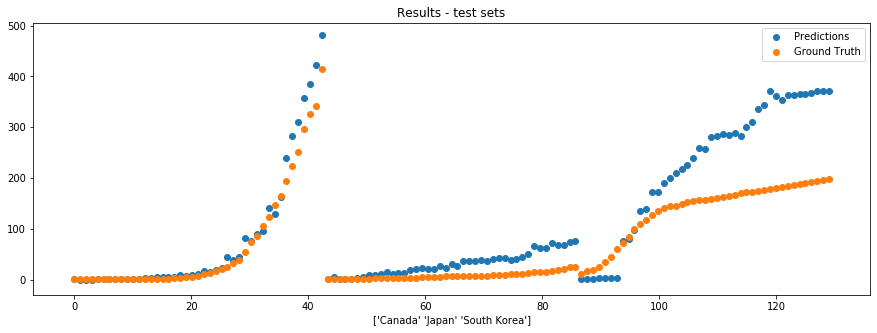

In [16]:


train_r2scores=[]
test_r2scores=[]
train_mse_scores=[]
test_mse_scores=[]
train_maxerror_scores=[]
test_maxerror_scores=[]
train_mae_scores=[]
test_mae_scores=[]

train_r2scores_scaled=[]
test_r2scores_scaled=[]
test_mae_scores_scaled=[]
train_mse_scores_scaled=[]
test_mse_scores_scaled=[]
train_maxerror_scores_scaled=[]
test_maxerror_scores_scaled=[]
train_mae_scores_scaled=[]

for train_idx,test_idx in group_kfold.split(all_features_2,all_labels,all_groups):
    #Train set
    train_countries=np.unique(np.array(covid_data.loc[train_idx]["country"]))
    X_train=all_features[train_idx]
    y_train=all_labels[train_idx]
    
    #Test & Validation set
    test_countries=np.unique(np.array(covid_data.loc[test_idx]["country"]))
    X_test=all_features[test_idx]
    y_test=all_labels[test_idx]

    #Scaling the data 
    scaler=StandardScaler()    
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
        
    model=RandomForestRegressor()
    #model=tree.DecisionTreeRegressor(max_depth=10)
    #model=MLPRegressor(hidden_layer_sizes=(100,),learning_rate='adaptive',max_iter=500)
    model.fit(X_train,y_train)
    
    predictions_train=model.predict(X_train)
    predictions_test=model.predict(X_test)
    
    #Scale the predicted and label values to [0,1] range
    scaler_l=MinMaxScaler()
    #y
    y_train_scaled=y_train.reshape(-1,1)
    y_train_scaled=scaler_l.fit_transform(y_train_scaled)
    y_train_scaled=y_train_scaled.reshape(-1)
    
    y_test_scaled=y_test.reshape(-1,1)
    y_test_scaled=scaler_l.fit_transform(y_test_scaled)
    y_test_scaled=y_test_scaled.reshape(-1)
    #pred
    predictions_train_scaled=predictions_train.reshape(-1,1)
    predictions_train_scaled=scaler_l.fit_transform(predictions_train_scaled)
    predictions_train_scaled=predictions_train_scaled.reshape(-1)       
    
    predictions_test_scaled=predictions_test.reshape(-1,1)
    predictions_test_scaled=scaler_l.fit_transform(predictions_test_scaled)
    predictions_test_scaled=predictions_test_scaled.reshape(-1)
      
        
    #Calculate values of metrics
    #Non-scaled
    r2_train=r2_score(y_train,predictions_train)
    r2_test=r2_score(y_test,predictions_test)
    
    mse_train=mse(y_train,predictions_train)
    mse_test=mse(y_test,predictions_test)
    
    me_train=max_error(y_train,predictions_train)
    me_test=max_error(y_test,predictions_test)
    
    mae_train=mean_absolute_error(y_train,predictions_train)
    mae_test=mean_absolute_error(y_test,predictions_test)    
    
    #Scaled
    r2_train_scaled=r2_score(y_train_scaled,predictions_train_scaled)
    r2_test_scaled=r2_score(y_test_scaled,predictions_test_scaled)
    
    mse_train_scaled=mse(y_train_scaled,predictions_train_scaled)
    mse_test_scaled=mse(y_test_scaled,predictions_test_scaled)
    
    me_train_scaled=max_error(y_train_scaled,predictions_train_scaled)
    me_test_scaled=max_error(y_test_scaled,predictions_test_scaled)
    
    mae_train_scaled=mean_absolute_error(y_train_scaled,predictions_train_scaled)
    mae_test_scaled=mean_absolute_error(y_test_scaled,predictions_test_scaled)  
    
    
    #Save results
    #Non-scaled
    train_r2scores.append(round(r2_train,4))
    test_r2scores.append(round(r2_test,4))
    
    train_mse_scores.append(round(mse_train,4))
    test_mse_scores.append(round(mse_test,4))
    
    train_maxerror_scores.append(round(me_train,4))
    test_maxerror_scores.append(round(me_test,4))
    
    train_mae_scores.append(round(mae_train,4))
    test_mae_scores.append(round(mae_test,4))
    
    #Scaled
    train_r2scores_scaled.append(round(r2_train_scaled,4))
    test_r2scores_scaled.append(round(r2_test_scaled,4))
    
    train_mse_scores_scaled.append(round(mse_train_scaled,4))
    test_mse_scores_scaled.append(round(mse_test_scaled,4))
    
    train_maxerror_scores_scaled.append(round(me_train_scaled,4))
    test_maxerror_scores_scaled.append(round(me_test_scaled,4))
    
    train_mae_scores_scaled.append(round(mae_train_scaled,4))
    test_mae_scores_scaled.append(round(mae_test_scaled,4))
    
    #Plot unscaled test results
    fig=plt.figure(figsize=(15,5))
    x=np.linspace(0,len(predictions_test),len(predictions_test))
    plt.scatter(x,predictions_test,label="Predictions")
    plt.scatter(x,y_test,label="Ground Truth")
    plt.xlabel(str(test_countries))
    plt.legend()
    plt.title("Results - test sets")
    plt.show()
    
    
results_train=pd.DataFrame(list(zip(train_r2scores,train_r2scores_scaled,train_mse_scores,train_mse_scores_scaled,train_maxerror_scores,train_maxerror_scores_scaled,train_mae_scores,train_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])

results_test=pd.DataFrame(list(zip(test_r2scores,test_r2scores_scaled,test_mse_scores,test_mse_scores_scaled,test_maxerror_scores,test_maxerror_scores_scaled,test_mae_scores,test_mae_scores_scaled)),
                          columns=["R2","R2_s","MSE","MSE_s","ME","ME_s","MAE","MAE_s"])




### Results train

In [17]:
results_train

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9987,0.9974,102.0730,0.0000,94.8939,0.0590,3.7957,0.0024
1,0.9972,0.9944,272.2758,0.0001,167.4192,0.0712,5.2912,0.0028
2,0.9970,0.9949,490.3395,0.0001,205.9841,0.1049,8.1147,0.0038
3,0.9970,0.9949,484.8621,0.0001,171.2140,0.0919,8.8101,0.0042
4,0.9970,0.9928,466.2639,0.0001,186.8210,0.1005,7.6835,0.0044


In [18]:
results_train.describe()

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000
mean,0.997380,0.994880,363.162860,0.000080,165.266440,0.085500,6.73904,0.003520
std,0.000743,0.001651,171.786786,0.000045,42.174723,0.019679,2.11147,0.000879
min,0.997000,0.992800,102.073000,0.000000,94.893900,0.059000,3.79570,0.002400
25%,0.997000,0.994400,272.275800,0.000100,167.419200,0.071200,5.29120,0.002800
50%,0.997000,0.994900,466.263900,0.000100,171.214000,0.091900,7.68350,0.003800
75%,0.997200,0.994900,484.862100,0.000100,186.821000,0.100500,8.11470,0.004200
max,0.998700,0.997400,490.339500,0.000100,205.984100,0.104900,8.81010,0.004400


### Results test

In [19]:
results_test

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
0,0.9160,0.9466,25305.5774,0.0021,796.5727,0.2347,72.3916,0.0240
1,0.9333,0.9811,15880.9369,0.0010,540.0891,0.1208,63.2665,0.0184
2,0.6070,0.7922,1506.4733,0.0075,169.0788,0.3202,17.8067,0.0398
3,-5.5798,0.8096,708.2846,0.0074,108.1263,0.3865,12.4834,0.0431
4,0.3644,0.6916,5002.8620,0.0142,192.0005,0.3400,44.9685,0.0749


In [20]:
results_test.describe()

,R2,R2_s,MSE,MSE_s,ME,ME_s,MAE,MAE_s
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.551820,0.84422,9680.826840,0.006440,361.173480,0.280440,42.183340,0.040040
std,2.820593,0.11876,10627.606973,0.005261,296.283656,0.104826,26.650998,0.022081
min,-5.579800,0.69160,708.284600,0.001000,108.126300,0.120800,12.483400,0.018400
25%,0.364400,0.79220,1506.473300,0.002100,169.078800,0.234700,17.806700,0.024000
50%,0.607000,0.80960,5002.862000,0.007400,192.000500,0.320200,44.968500,0.039800
75%,0.916000,0.94660,15880.936900,0.007500,540.089100,0.340000,63.266500,0.043100
max,0.933300,0.98110,25305.577400,0.014200,796.572700,0.386500,72.391600,0.074900


After removing the features that don't have a lot of weight, results show a lot of improvement!
In the next approach, some additional features will be added - more temporal features - along with the removal of some countries with lower number of cases that may prejudice the model to a good generalization.